# Spectral Subgraph Localization

**Author**: Amit Boyarski

## Intro

We are interested in solving the problem of **subgraph localization**:

Given a full graph $\mathcal{G}$ and a subgraph $\mathcal{H}$, find a subgraph (i.e., a set of nodes and edges) within $\mathcal{G}$ that matches $\mathcal{H}$ as close as possible.

The desired output is a scalar field over $\mathcal{G}$ denoting the probabilities of each node and edge belonging to $\mathcal{H}$. Note that this is a superficially simpler problem than finding full correspondence between $\mathcal{H}$ and $\mathcal{G}$.

We approach the problem by modeling it as an optimization problem over $\mathcal{G}$. Let use denote by $\mathbf{v} : \mathcal{N}\rightarrow \mathbb{R}^{\mathcal{N}}$ and $\mathbf{E}: {\mathcal{N} \times \mathcal{N}}\rightarrow \mathbb{R}^{\mathcal{N} \times \mathcal{N}}$ two scalar fields (i.e., "masks") over the nodes and edges of $\mathcal{G}$. We shall denote the Laplacian of $\mathcal{G}$ by $\mathbf{L} = \mathbf{D}-\mathbf{A}$, where $\mathbf{A}$ is the adjacency matrix $\mathbf{D}\equiv \textbf{diag}(\mathbf{A}\mathbf{1})$ is the degree matrix of $\mathcal{G}$.

The edge potential $\mathbf{E}$ is used to detach the subgraph from the full graph, i.e., by demanding $\mathbf{L}_E = \mathbf{L}+\mathbf{E}$ to be a Laplacian of a graph composed of two disconnected components (one of which corresponds to $\mathcal{H}$). Once the subgraph has been detached, we use the node potential $\mathbf{v}$ to modify the spectrum of the edited Laplacian $\mathbf{L}_E$ such that it should match the spectrum of the Laplacian of $mathcal{H}$.

To that end, we model the problem via an optimization problem with a data term and regularization terms:


$$
\min_{\mathbf{E},\mathbf{v}} \mu_{spect}\|\mathbf{\lambda}(\mathbf{L}+\mathbf{E}+\text{diag}(\mathbf{v})) - \mathbf{\lambda}_{ref}\|^2 +
 \mu_{sparse} \|\mathbf{E}\|_1+\mu_{split}\lambda_{2}(\mathbf{L}+\mathbf{E})+\mu_{MS} \mathbf{v}^T\bigl( \mathbf{L}+\mathbf{E}\bigr) \mathbf{v}
$$
$$
\text{s.t.}\;\;\mathbf{E}=\mathbf{E}^\top,\mathbf{E}\mathbf{1}=\mathbf{0},\;\text{offdiag}(\mathbf{L}+\mathbf{E})\leq 0,\;\text{tr}(\mathbf{E}) = k
$$


- The first term (spectral alignment term) is supposed to align the spectra of the localized subgraph with that of the reference subgraph $\mathcal{H}$.
- The second term is supposed to restrict the number of detached edges, e.g., by making the editing  Laplacian matrix sparse.
- The third term penalizes the second eigenvalue of the edited Laplacian, thus enforcing the edited graph to have disconnected components.
- The fourth term is in order to make sure that $\mathbf{v}$ is piecewise constant, i.e., it should equal $0$ outside our subgraph and $\infty$ (or some large number) on the subgraph. Alternatively, it pushes $\mathbf{v}$ into the nullspace of the edited Laplacian.
- The constraints ensure that $\mathbf{L}_E$ is a valid Laplacian.

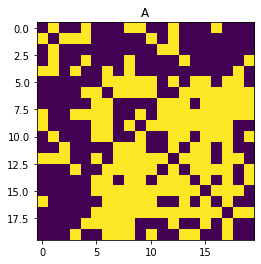

In [1]:
from optimization.prox.prox import ProxNonNeg, ProxL21ForSymmCentdMatrixAndInequality
import torch
import matplotlib.pyplot as plt
from problem.spectral_subgraph_localization import block_stochastic_graph, \
    SubgraphIsomorphismSolver

torch.manual_seed(12)

n1 = 5
n2 = 15
n = n1 + n2
p = block_stochastic_graph(n1, n2, p_parts=0.7, p_off=0.2)

A = torch.tril(torch.bernoulli(p)).double()
A = (A + A.T)
D = torch.diag(A.sum(dim=1))
L = D - A

plt.imshow(A)
plt.title('A')
plt.show()

A_sub = A[0:n1, 0:n1]
D_sub = torch.diag(A_sub.sum(dim=1))
L_sub = D_sub - A_sub
ref_spectrum = torch.linalg.eigvalsh(L_sub)


  0%|          | 0/100 [00:00<?, ?it/s]/Users/amitboy/.local/share/virtualenvs/GraphMatching-LGBFh8ro/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 100/100 [00:02<00:00, 43.02it/s]


done
v= tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0491, 0.0461, 0.0484, 0.0405,
        0.0459, 0.0459, 0.0441, 0.0407, 0.0461, 0.0492, 0.0487, 0.0454, 0.0484,
        0.0354, 0.0412], dtype=torch.float64, requires_grad=True)
E= tensor([[-3.0081e-02, -9.7182e-02, -2.2063e-12, -3.2903e-12,  1.0058e-01,
         -4.8741e-12, -7.3793e-12, -4.6386e-12,  1.9399e-02,  1.2852e-10,
         -6.8648e-12, -9.5909e-12,  7.2800e-03, -7.4950e-12, -4.5045e-12,
         -5.3043e-12,  1.4286e-10, -5.3361e-12, -4.5494e-12, -4.4912e-12],
        [-9.7182e-02, -5.8353e-01,  6.0186e-01, -1.3103e-02,  1.2009e-01,
         -5.2346e-12, -8.9078e-12, -5.1591e-12, -9.5876e-11, -8.7672e-12,
         -7.4599e-12, -1.2612e-11, -2.8138e-02, -1.4483e-11, -5.2902e-12,
         -5.9435e-12, -9.5987e-12, -6.1900e-12, -4.4454e-12, -7.7031e-12],
        [-2.2063e-12,  6.0186e-01, -1.0595e+00, -1.9322e-12, -2.0512e-12,
         -2.4682e-12, -2.9435e-12, -2.5623e-12, -3.8011e-12, -2.7582e-12,
         -2.6080e-12,

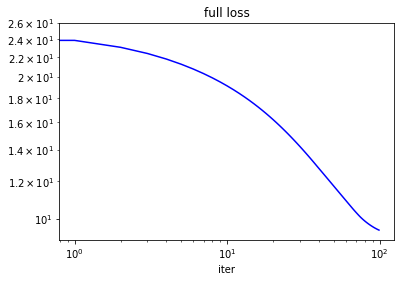

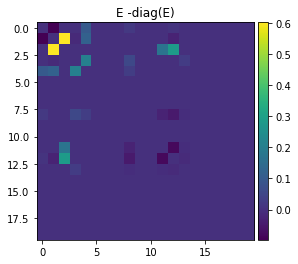

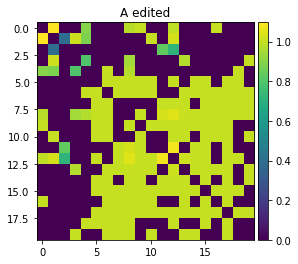

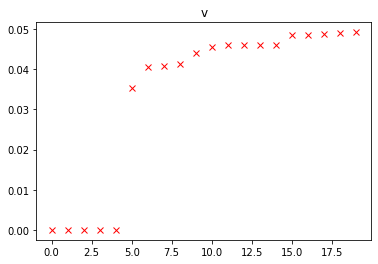

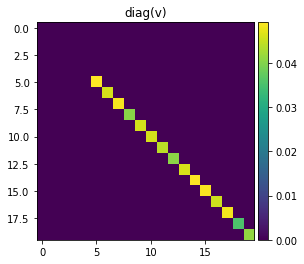

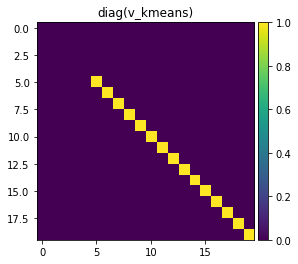

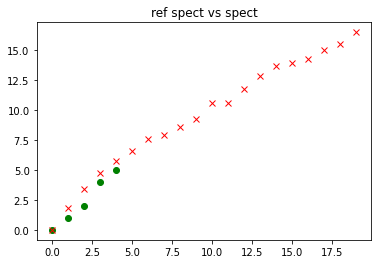

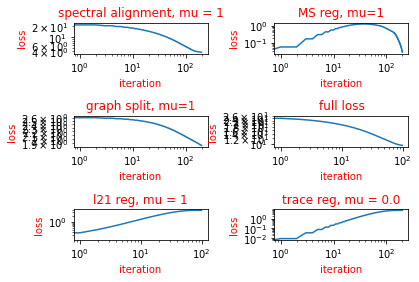

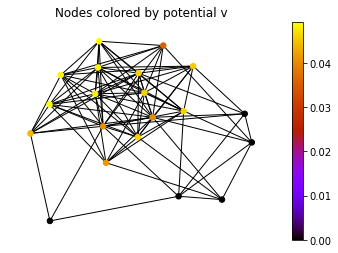

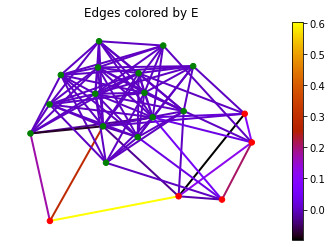

In [2]:

params = {'maxiter': 100,
          'mu_spectral': 1,
          'mu_l21': 1,
          'mu_MS': 1,
          'mu_split': 1,
          'mu_trace': 0.0,
          'lr': 0.02,
          'v_prox': ProxNonNeg(),
          #'E_prox': ProxL21ForSymmetricCenteredMatrix(solver="cvx"),
          'E_prox': ProxL21ForSymmCentdMatrixAndInequality(solver="cvx", L=L,
                                                            trace_upper_bound=
                                                            1.1*torch.trace(L)),
          'trace_val': 0
          }
plots = {
    'full_loss': True,
    'E': True,
    'v': True,
    'diag(v)': True,
    'v_otsu': False,
    'v_kmeans': True,
    'A edited': True,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': True}
subgraph_isomorphism_solver = \
    SubgraphIsomorphismSolver(L, ref_spectrum, params, plots)
v, E = subgraph_isomorphism_solver.solve()
subgraph_isomorphism_solver.plot()
subgraph_isomorphism_solver.plot_on_graph(A.numpy().astype(int),n1)